In [1]:
import numpy as np
import pandas as pd
import random
import time
import math
import random
import os
import sys
from datetime import datetime
import matplotlib.pyplot as plt

# Notebook path
current_directory = os.getcwd()
# Get one behind for calling the other modules
root_directory = os.path.abspath(os.path.join(current_directory, '..'))
sys.path.append(root_directory)

#Network and measures
from to_get_data.net_construction_vis_measures import *
#Agrobiodiversity
from to_get_data.agrobiodiversity_data import *

from model_class.Variety import Variety

# Clase prueba. No importa

In [2]:
## CLase UD 
## Class with endogamy. In other words, UDs in this model belong to the same clan and the only criteria is 
# the incest rule and some probabilities related to distance. 
#This particular Class is used to set a limit in the number of UD on the model 0,1,2,3,4,5,7,8
###Relações na lista de parentes
#0. Pais do homem [0]
#1. Pais da mulher [1]
#2. Filhos [2]
#3. Avos [3] 
#4. Irmãos [4]
#5. Tios [5]
#6. Primos [6]
#7. Netos [7]
#8. Sobrinhos [8]
#9. Cassais passados [9]

### Filhos tem sexo e idade
#[sexo, idade]

class UD:
    #Dict de todas as UDs
    uds = {}

    def __init__(self, id_ud, media, community):
        self.id = id_ud
        self.parentes = [None]*10
        self.age = 1
        self.filhos = [None] * (np.random.poisson(media))
        self.uds[id_ud] = self
        self.activa = True 
        self.varieties = []
        self.community = community

    def ter_filho(self):
        # Tem espaco para ter filhos?, aleatoriamente para nao ter filhos todo ano. 
        if None in self.filhos and random.random() <= 0.3:
            # Coloca o filho no primeiro None
            for i in range(len(self.filhos)):
                if self.filhos[i] is None:
                    self.filhos[i] = [random.choice([0, 1]), 0] #[sexo, idade] e no sexo: 0 é feminino e 1 é masculino
                    break
        else:
            pass #print(f"Unidade {self.id} No tem para ter filhos!")

    def incrementar_idade(self):
        self.age += 1
        ## idade dos filhos no self.filhos
        for i in range(len(self.filhos)):
            if self.filhos[i] is not None:
                self.filhos[i][1] += 1
            else:
                break

    def death_probability(self, beta):
        alpha = 0.01
        delta = 0.00
        mortality_rate = alpha * math.exp(beta * (self.age)) + delta

        if random.random() < mortality_rate:
            self.activa = False

    def buscar_ud(self, media, matrilinear, locality): #metodo para buscar e reproducir.
        #Function to get a random couple
        def select_new_ud (selected_ud, uds_disponiveis):
            if len(uds_disponiveis) != 0: #If there are no possible mates
                #La verdad creo que es mas eficiente si no creo los ceros sino una con las comunidades y ahi opero sobre eso.
                probabilidad = np.zeros(len(uds_disponiveis))
                for i, obj in enumerate(uds_disponiveis):
                    if obj.community == selected_ud.community:
                        # Asignar una probabilidad alta si el objeto pertenece a la misma comunidad
                        probabilidad[i] = 1.0
                    else:
                        # Asignar una probabilidad uniforme si el objeto pertenece a una comunidad diferente
                        probabilidad[i] = 1.0 / len(uds_disponiveis)
                prob_normalized = probabilidad / np.sum(probabilidad)
                #print(len(prob_normalized))
                choosen_ud = np.random.choice(uds_disponiveis, p=prob_normalized)
                return choosen_ud
            else:
                return False
        
        #Função para facilitar a busqueda de ids dentro da lista de parentes.
        def is_id_in_nested_lists(id_ud, nested_list):
            if id_ud in nested_list:
                return True
            for sublist in nested_list:
                if isinstance(sublist, list) and is_id_in_nested_lists(id_ud, sublist):
                    return True
            return False
        
        #Função para facilitar a busqueda de filhos segundo o sexo
        def filho_e_idade(self, sexo):
            for i in range(len(self.filhos)):
                filho = self.filhos[i]
                #Se o sexo é o que estamos procurando e se a idade é permitida para o casamento
                if filho is not None and filho[0] == sexo and filho[1] > 13:
                    return (True, i, filho[1])  # True, a posição e a idade

            return (False, None, None)  # False, None e None
        
        filha_disponivel, posição_filha, idade_filha = filho_e_idade(self, 0) #Se a unidade tem uma filha disponivel para procurar esposa
        if filha_disponivel:
            uds_disponiveis = [ud for id_ud, ud in self.uds.items() if
                    id_ud != self.id and #Que a UD não seja self
                    not is_id_in_nested_lists(id_ud, [self.parentes[i] for i in [0, 1, 2, 3, 4, 5, 7, 8]]) and # Que a UD não seja um parent
                    filho_e_idade(ud,1)[0] and #Que tenha um filho
                    abs(filho_e_idade(ud,1)[2] - idade_filha) <= 13 #Que a diferença entre as idades não seja maior a 10
                      ]
            new_couple = select_new_ud(self, uds_disponiveis)
            
            if new_couple:
                cassal_id = new_couple.id
                filho_disponivel, posição_filho, idade_filho = filho_e_idade(UD.uds[cassal_id], 1)
                #print(filho_disponivel, posição_filho, idade_filho)
                #Agregar no espaço de casais passados [9]
                if self.parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.parentes[9] = [cassal_id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.parentes[9].append(cassal_id)
                if self.uds[cassal_id].parentes[9] is None: 
                    # Se a lista não existe, cria uma nova com esse id
                    self.uds[cassal_id].parentes[9] = [self.id]
                else:
                    # Se a lista já existe, só agrega o id
                    self.uds[cassal_id].parentes[9].append(self.id)   

                #### Criar um novo filho e asignar os parentes
                novo_id = max(self.uds) + 1
                if locality == True:
                    novo_nodo = UD(novo_id, media, self.uds[cassal_id].community)
                else:
                    novo_nodo = UD(novo_id, media, self.community)
                novo_nodo.parentes[0] = self.id   # Pais do homem [0]
                novo_nodo.parentes[1] = cassal_id # Pais da mulher [1] 
                
                #####Avos[3]
                # IDs do pai
                padre_self = self.parentes[0]
                madre_self = self.parentes[1]
                # IDs da mae
                pareja = self.uds[cassal_id]
                padre_pareja = pareja.parentes[0]
                madre_pareja = pareja.parentes[1]
                # Agregar os pais dos pais do novo_nodo como avos
                novo_nodo.parentes[3] = [valor for valor in [padre_self, madre_self, padre_pareja, madre_pareja] if valor is not None]
                ###Proceso de atualização: netos
                # Se novo_nodo tem avos 
                if None not in novo_nodo.parentes[3]:
                    # IDs dos avos de novo_nodo
                    abuelos_ids = novo_nodo.parentes[3]
                # Agregar aos avos o novo_nodo como neto.
                for abuelo_id in abuelos_ids:
                    if abuelo_id is not None:
                        abuelo = self.uds[abuelo_id]
                        if abuelo.parentes[7] is None:
                            abuelo.parentes[7] = [novo_nodo.id]
                        else:
                            abuelo.parentes[7].append(novo_nodo.id)
                
                #### Irmãos [4]
                hermanos_ids = []
                if novo_nodo.parentes[0] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte do pai)
                    padre_nuevo = self.uds[novo_nodo.parentes[0]]
                    if padre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(padre_nuevo.parentes[2])
                if novo_nodo.parentes[1] is not None:
                    # Filhos dos pais do novo_nodo (irmãos por parte da mãe)
                    madre_nuevo = self.uds[novo_nodo.parentes[1]]
                    if madre_nuevo.parentes[2] is not None:
                        hermanos_ids.extend(madre_nuevo.parentes[2])
                # Não ter o id de novo_nodo como irmão
                hermanos_ids = [hermano_id for hermano_id in hermanos_ids if hermano_id != novo_nodo.id]
                # Agregar aos irmãos de novo_nodo
                novo_nodo.parentes[4] = hermanos_ids
                
                ##Proceso de atualização: irmãos
                # ID de novo_nodo nos irmãos existentes
                for hermano_id in hermanos_ids:
                    hermano = self.uds[hermano_id]
                    if hermano.parentes[4] is None:
                        hermano.parentes[4] = [novo_nodo.id]
                    else:
                        hermano.parentes[4].append(novo_nodo.id)
                #####Tios[5]
                # IDs dos avos de novo_nodo
                abuelos_ids = novo_nodo.parentes[3]
                
                # Iterar nos avos para encontrar os tios
                tios_ids = [hermano_id for abuelo_id in abuelos_ids if abuelo_id is not None
                            for hermano_id in self.uds[abuelo_id].parentes[2] if hermano_id is not None
                            if hermano_id != novo_nodo.parentes[0] and hermano_id != novo_nodo.parentes[1]]
                # Agregar os IDs dos tios no novo_nodo
                novo_nodo.parentes[5] = tios_ids
                
                ##Proceso de atualização: sobrinhos
                # Actualizar os sobrinhos dos tios.
                for tio_id in tios_ids:
                    if tio_id is not None:
                        tio = self.uds[tio_id]
                        if tio.parentes[8] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            tio.parentes[8] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            tio.parentes[8].append(novo_nodo.id)
                
                #### Primos[6]
                primos_ids = [primo_id for tio_id in tios_ids if tio_id is not None
                            for tio in [self.uds[tio_id]] if tio.parentes[2] is not None
                            for primo_id in tio.parentes[2] if primo_id is not None and primo_id != novo_nodo.id]

                # Agregar os IDs dos primos no novo_nodo
                novo_nodo.parentes[6] = primos_ids
                
                ##Proceso de atualização: sobrinhos
                for primo_id in primos_ids:
                    if primo_id is not None:
                        primo = self.uds[primo_id]
                        if primo.parentes[6] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            primo.parentes[6] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            primo.parentes[6].append(novo_nodo.id)
                            
                ####Sobrinos[8] 
                sobrinos_ids = [sobrino_id for hermano_id in hermanos_ids if hermano_id is not None
                                for hermano in [self.uds[hermano_id]] if hermano.parentes[2] is not None
                                for sobrino_id in hermano.parentes[2] if sobrino_id is not None and sobrino_id != novo_nodo.id]

                # Agregar os IDs dos sobrinhos no novo_nodo
                novo_nodo.parentes[8] = sobrinos_ids
                
                ##Proceso de atualização: tios
                for sobrino_id in sobrinos_ids:
                    if sobrino_id is not None:
                        sobrino = self.uds[sobrino_id]
                        if sobrino.parentes[5] is None:
                            # Se não existe, cria lisa com o id de novo_nodo
                            sobrino.parentes[5] = [novo_nodo.id]
                        else:
                            # Se existe, agregar o id de novo_nodo
                            sobrino.parentes[5].append(novo_nodo.id)
                            
                            
                ### Eliminar os filhos utilizados no processo
                self.filhos.pop(posição_filha)
                self.uds[cassal_id].filhos.pop(posição_filho)
                
                # colcoar o novo filho dos pais
                if self.parentes[2] is None:
                    self.parentes[2] = [novo_id]
                else:
                    self.parentes[2].append(novo_id)
                if self.uds[cassal_id].parentes[2] is None:
                    self.uds[cassal_id].parentes[2] = [novo_id]
                else:
                    self.uds[cassal_id].parentes[2].append(novo_id)
                
                # Herdar sementes
                novo_nodo.heredar(matrilinear)
                
                #return None
            else:
                #print(f"UD {self.id} não achou cassal.")
                return None

        else:
            #print(f"UD {self.id} não achou ninguem")
            return None

    def heredar(self, matrilinear): #Metodo da herança de sementes.
        vm = UD.uds[self.parentes[1]].varieties
        vp = UD.uds[self.parentes[0]].varieties
        heredar_mae = math.ceil((matrilinear * len(vm))/100)
        heredar_pai = math.ceil(((100-matrilinear) * len(vp))/100)
        vari_mae = vm[0:heredar_mae] #as primeiras variedades
        vari_pai = vp[0:heredar_pai] #as primeiras variedades
        # Mutacao
#        if random.random() < 0.001:
#            # uma aleatoria
#            variedad_a_mutar = random.choice(vari_mae + vari_pai)
#            # mutacao
#            variedad_a_mutar.mutation()

        # Heredar as variedades
        self.varieties.extend(vari_mae + vari_pai)

In [3]:
#Formato de documento: 
    #Lista [step, id, age, parentes, community, varieties, variedades únicas]
    #Creo que le corresponde a alguien afuera para guardarlo.
def general_charactersitics_data(G, step, uds, dataset, data_conections, final = False):
    if final == False:
        for ud in uds.values():
            #unicas = 
            dataset.append([step, ud.id, ud.age, ud.parentes, ud.community, ud.varieties])#, unicas])
        # Obtener las aristas del grafo G
        edges = list(G.edges())

        # Crear un DataFrame para las aristas con las columnas 'step', 'source' y 'target'
        df_edges = pd.DataFrame(edges, columns=['source', 'target'])

        # Insertar la columna 'step' antes de 'source' con el valor proporcionado
        df_edges.insert(0, 'step', step)
        df_final_edges = pd.concat([data_conections, df_edges], ignore_index=True)
        return dataset, df_final_edges
            

    else:
        df = pd.DataFrame(dataset)
        df.columns = ["Step", "ID", "Age", "Parents", "Community", "Varieties"]# "Unique"]
        return df, data_conections

In [3]:
def create_edges_dataframe(G, step):
    # Obtener las aristas del grafo G
    edges = list(G.edges())
    
    # Crear un DataFrame para las aristas con las columnas 'step', 'source' y 'target'
    df_edges = pd.DataFrame(edges)#, columns=['source', 'target'])
    
    # Insertar la columna 'step' antes de 'source' con el valor proporcionado
    df_edges.insert(0, 'step', step)
    df_final_edges = pd.concat(data_conections, df_edges, ignore_index=True)
    return df_final_edges

# Experimentos

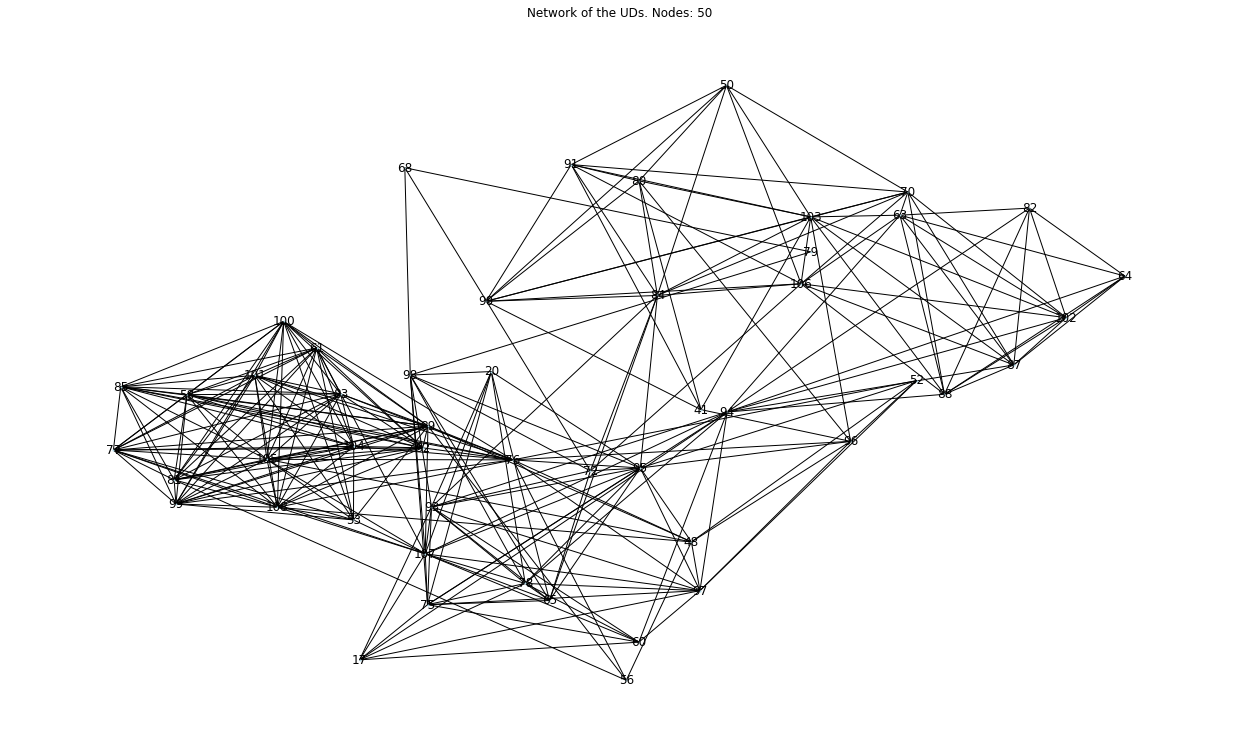

Betweenness Centrality:
{107: 0.24514322492033339, 76: 0.16193979494318986, 94: 0.15741496457375564, 96: 0.11222284047794466, 95: 0.11189433452898982, 84: 0.09423186242410629, 98: 0.06209088564746846, 103: 0.06092078948493411, 97: 0.051241775041715475, 93: 0.04304466838314338}

Closeness Centrality:
{107: 0.550561797752809, 95: 0.5384615384615384, 97: 0.5212765957446809, 76: 0.5212765957446809, 93: 0.5104166666666666, 96: 0.5, 94: 0.4803921568627451, 48: 0.4803921568627451, 89: 0.47572815533980584, 105: 0.47115384615384615}

Degree Centrality:
{89: 0.36734693877551017, 107: 0.3469387755102041, 76: 0.3469387755102041, 105: 0.3469387755102041, 108: 0.3469387755102041, 61: 0.3061224489795918, 77: 0.3061224489795918, 104: 0.3061224489795918, 99: 0.3061224489795918, 100: 0.3061224489795918}

Eigenvector Centrality:
{89: 0.2711069161268101, 105: 0.2674736440251656, 108: 0.2674736440251656, 104: 0.25384351664863725, 99: 0.25384351664863725, 100: 0.25384351664863725, 101: 0.25384351664863725, 

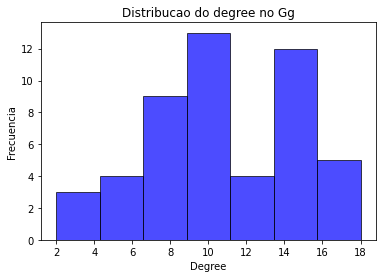

Densidade: 0.21877551020408162
Número de nós: 50
Número de aristas: 268
Diámetro: 5
Transitividade: 0.7425348374253484
Average shorthest path: 2.4081632653061225
Coeficiente de Clustering Promedio (cluster maior): 0.7592379026202556
----------------------------


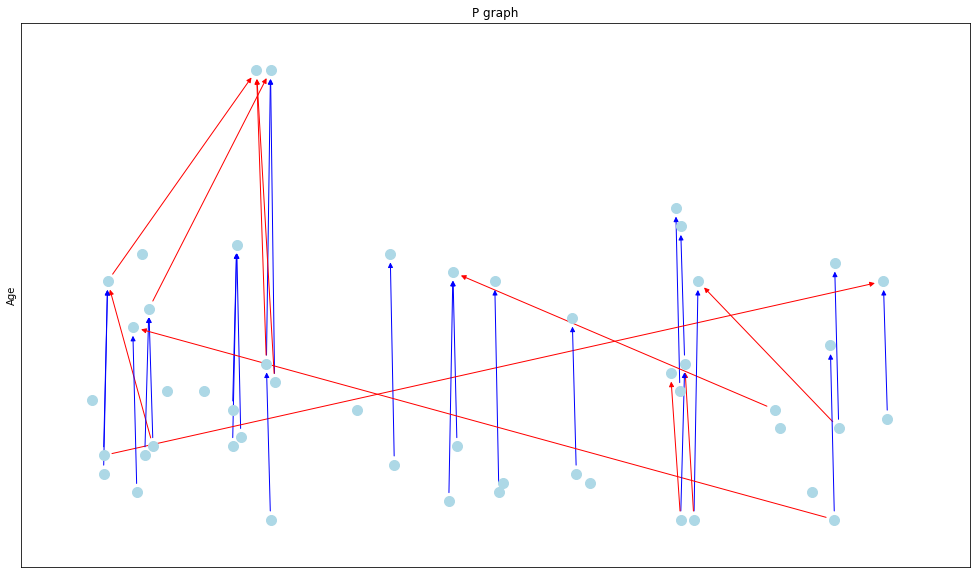

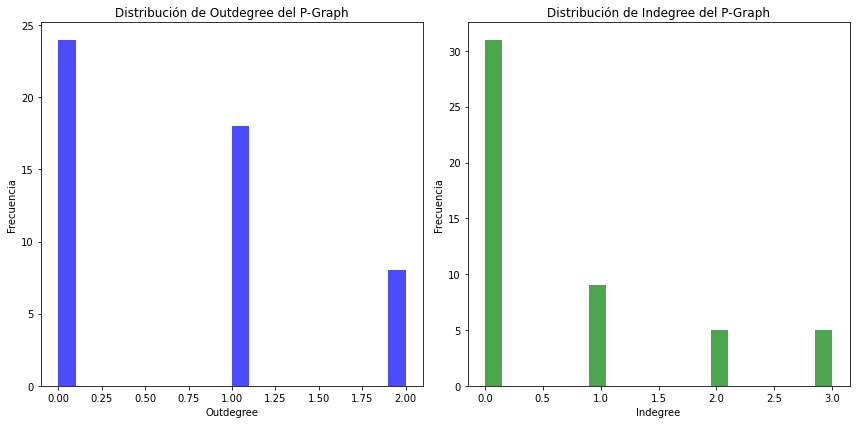

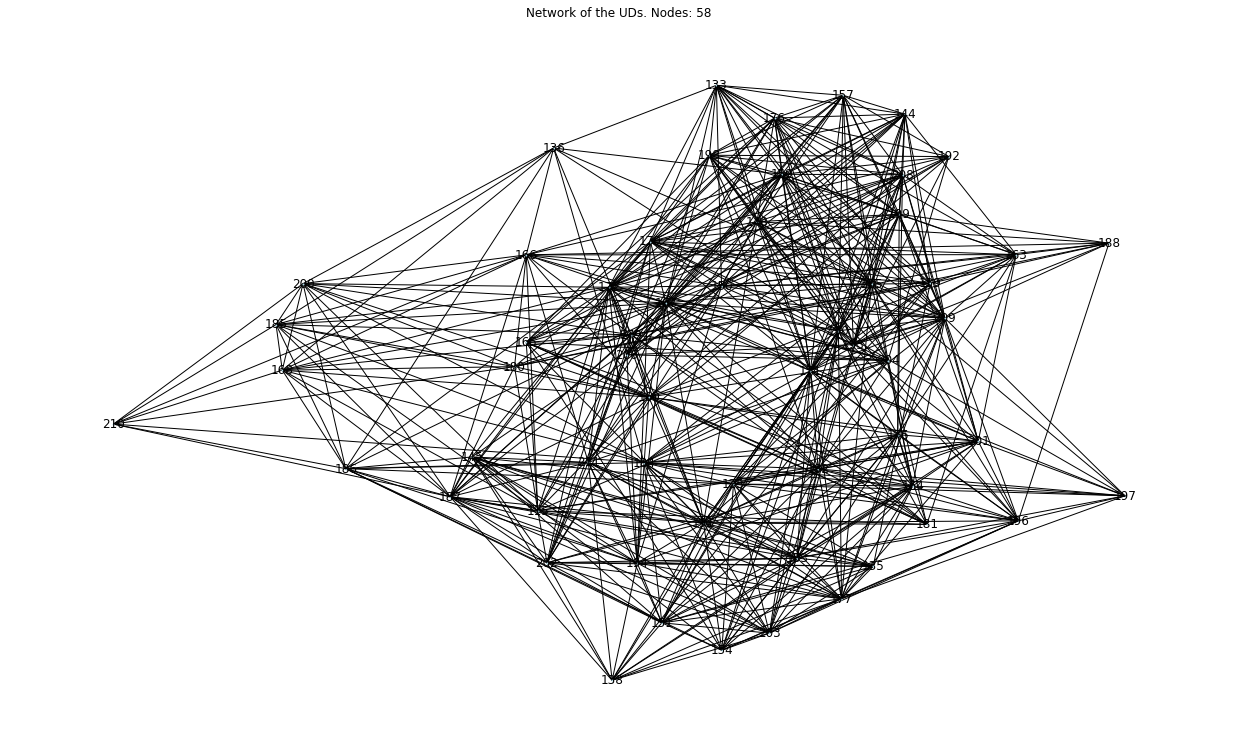

Betweenness Centrality:
{167: 0.041980452103417186, 172: 0.03907836555690323, 171: 0.032167335190559344, 187: 0.03192498975016304, 184: 0.03133835941523111, 209: 0.030941163797540545, 191: 0.02845103913154525, 190: 0.02841341540605056, 179: 0.02153646934819052, 170: 0.021531745524111776}

Closeness Centrality:
{167: 0.7037037037037037, 172: 0.6951219512195121, 171: 0.6951219512195121, 209: 0.6867469879518072, 190: 0.6785714285714286, 191: 0.6705882352941176, 182: 0.6477272727272727, 159: 0.6477272727272727, 187: 0.6404494382022472, 205: 0.6404494382022472}

Degree Centrality:
{167: 0.5789473684210527, 172: 0.5614035087719298, 171: 0.5614035087719298, 209: 0.5438596491228069, 190: 0.5263157894736842, 191: 0.5087719298245614, 182: 0.45614035087719296, 159: 0.45614035087719296, 187: 0.43859649122807015, 205: 0.43859649122807015}

Eigenvector Centrality:
{171: 0.21955803606536523, 209: 0.20828293108571064, 190: 0.20739453635106103, 167: 0.20509514378458407, 172: 0.20004409542182436, 191: 0

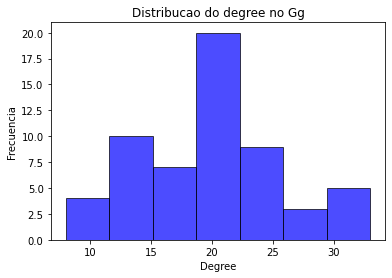

Densidade: 0.3484573502722323
Número de nós: 58
Número de aristas: 576
Diámetro: 3
Transitividade: 0.5841517101252963
Average shorthest path: 1.6793708408953418
Coeficiente de Clustering Promedio (cluster maior): 0.6170571592821176
----------------------------


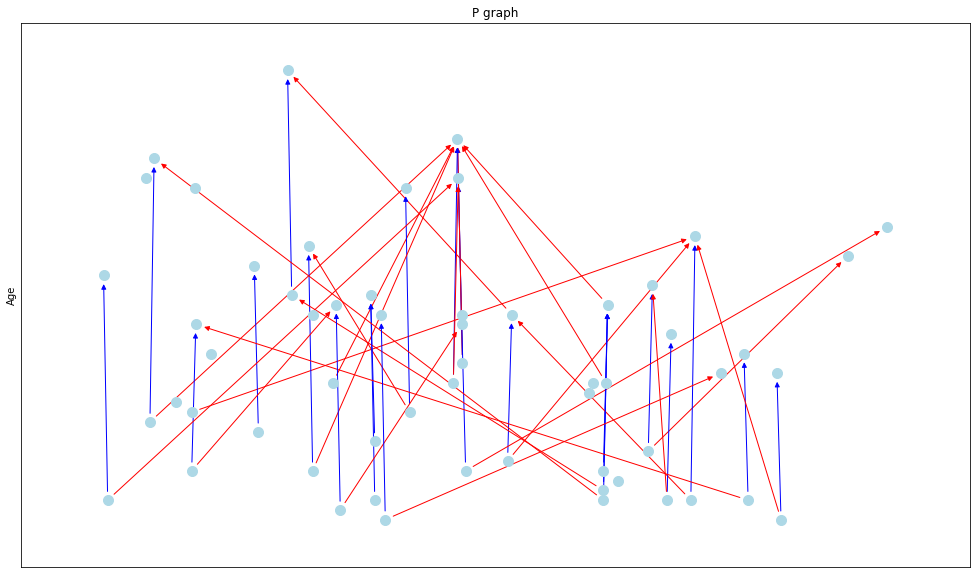

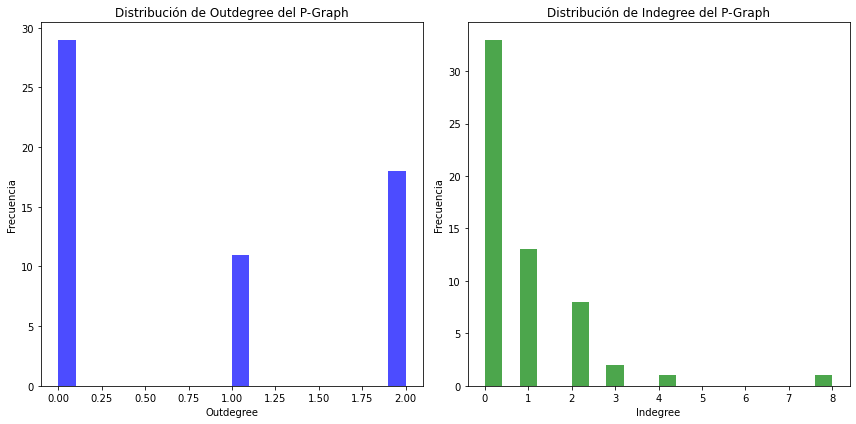

tamos en tiempo 100 con vivas 56
56


In [4]:
### Para cambiar
iniciais = 40 # Initial UD
prob_morte = 0.06 # Beta from the gutertz equation
media = 4 # Average children per UD
random.seed(42) # Random seed
t = 101 #steps of the simulation
### To save the data
dataset = []
data_conections = pd.DataFrame(columns=['step','source', 'target'])
#### Initialization
## Comunidades
UD.uds = {}
comunidades_disponibles = [i for i in range(1, (int(iniciais) // 10) + 1) for _ in range(10)]
instancias_ud = []
for id_ud in range(1, int(iniciais) + 1):
    instancias_ud.append(UD(id_ud, media, comunidades_disponibles.pop(0)))
## Variedades y repartirlas entre las comunidades
for id_ud, ud in UD.uds.items():
    for _ in range(5):
        ud.varieties.append(Variety())     
    #### Simulation
original_media = media
vivas = [int(iniciais)]
for i in range(1, t):
    uds_copy = {id_ud: ud for id_ud, ud in UD.uds.items() if ud.activa}
        # if not alive
    if not uds_copy:
        print("acabo")
        break
    if i % 50 == 0:
        Gg = create_vis_geral(uds_copy, True)
        p_graph(uds_copy, True)
        dataset, data_conections = general_charactersitics_data(Gg, i, uds_copy, dataset, data_conections)        

    for id_ud, ud in uds_copy.items():
        ud.ter_filho()
        ud.buscar_ud(media, 50, True)
        ud.incrementar_idade()
        ud.death_probability(prob_morte)
     # Collecting data
    viv = len([ud for id, ud in uds_copy.items() if ud.activa])
    #mort = len([ud for id, ud in uds_copy.items() if not ud.activa])
    vivas.append(viv)
    #mortas.append(mort)
    #tempo.append(t)
    if i%100 == 0:
        print(f"tamos en tiempo {i} con vivas {viv}")
print(len([ud for id, ud in uds_copy.items() if ud.activa]))
ejemplo, ejemplo_conections = general_charactersitics_data(0,0,0, dataset, data_conections, True)

In [5]:
ejemplo_conections

,step,source,target
0,50,37,99
1,50,37,111
2,50,37,113
3,50,99,63
4,50,99,71
...,...,...,...
894,100,247,231
895,100,247,245
896,100,247,248
897,100,248,231


ModuleNotFoundError: No module named 'plotly'

In [9]:
nx.get_node_attributes(Gg, 'Community')

{139: 2,
 173: 2,
 182: 1,
 193: 3,
 211: 3,
 148: 2,
 155: 1,
 168: 2,
 146: 4,
 159: 3,
 206: 3,
 220: 2,
 224: 2,
 225: 1,
 228: 2,
 229: 3,
 230: 1,
 235: 2,
 238: 1,
 185: 2,
 187: 2,
 196: 1,
 200: 4,
 202: 2,
 207: 1,
 209: 1,
 210: 1,
 215: 4,
 216: 3,
 218: 1,
 232: 1,
 237: 1,
 240: 1,
 242: 1,
 245: 3,
 140: 1,
 172: 2,
 217: 2,
 165: 2,
 169: 3,
 183: 2,
 191: 2,
 195: 4,
 170: 2,
 231: 2,
 234: 2,
 243: 3,
 167: 3,
 177: 1,
 190: 3,
 223: 2,
 236: 2,
 154: 3,
 198: 3,
 201: 3,
 156: 4,
 161: 3,
 178: 4,
 179: 3,
 241: 2,
 199: 3,
 212: 4,
 233: 3,
 239: 3,
 221: 2,
 227: 4,
 244: 3,
 186: 4,
 214: 1}

In [7]:
ejemplo

,Step,ID,Age,Parents,Community,Varieties
0,50,37,50,"[None, None, [51, 58, 64], None, None, None, N...",4,[<model_class.Variety.Variety object at 0x0000...
1,50,47,33,"[13, 17, [92, 100, 104], [], [49, 54, 73, 75, ...",2,[<model_class.Variety.Variety object at 0x0000...
2,50,50,33,"[27, 14, [92, 95, 100, 107], [], [67, 69, 70, ...",2,[<model_class.Variety.Variety object at 0x0000...
3,50,60,31,"[19, 36, [93, 98, 109, 117, 120], [], [74, 83]...",4,[<model_class.Variety.Variety object at 0x0000...
4,50,63,30,"[24, 16, [99, 127, 132], [], [41, 49, 71, 74],...",2,[<model_class.Variety.Variety object at 0x0000...
...,...,...,...,...,...,...
103,100,248,2,"[194, 179, None, [147, 140, 136, 131], [231, 2...",4,[<model_class.Variety.Variety object at 0x0000...
104,100,249,2,"[196, 171, None, [151, 137, 136, 124], [243, 2...",4,[<model_class.Variety.Variety object at 0x0000...
105,100,250,1,"[167, 185, None, [130, 123, 147, 135], [219, 2...",1,[<model_class.Variety.Variety object at 0x0000...
106,100,251,1,"[179, 195, None, [136, 131, 150, 128], [232, 2...",1,[<model_class.Variety.Variety object at 0x0000...


[50 100]


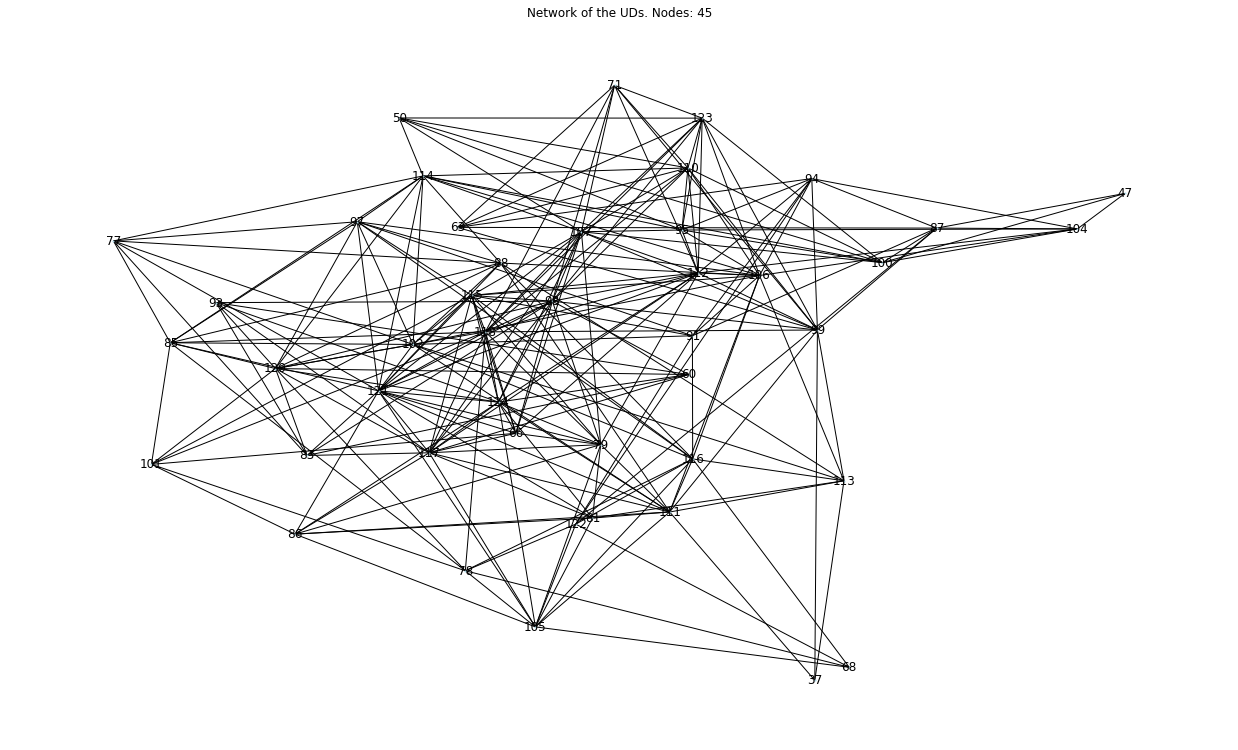

----------------------------


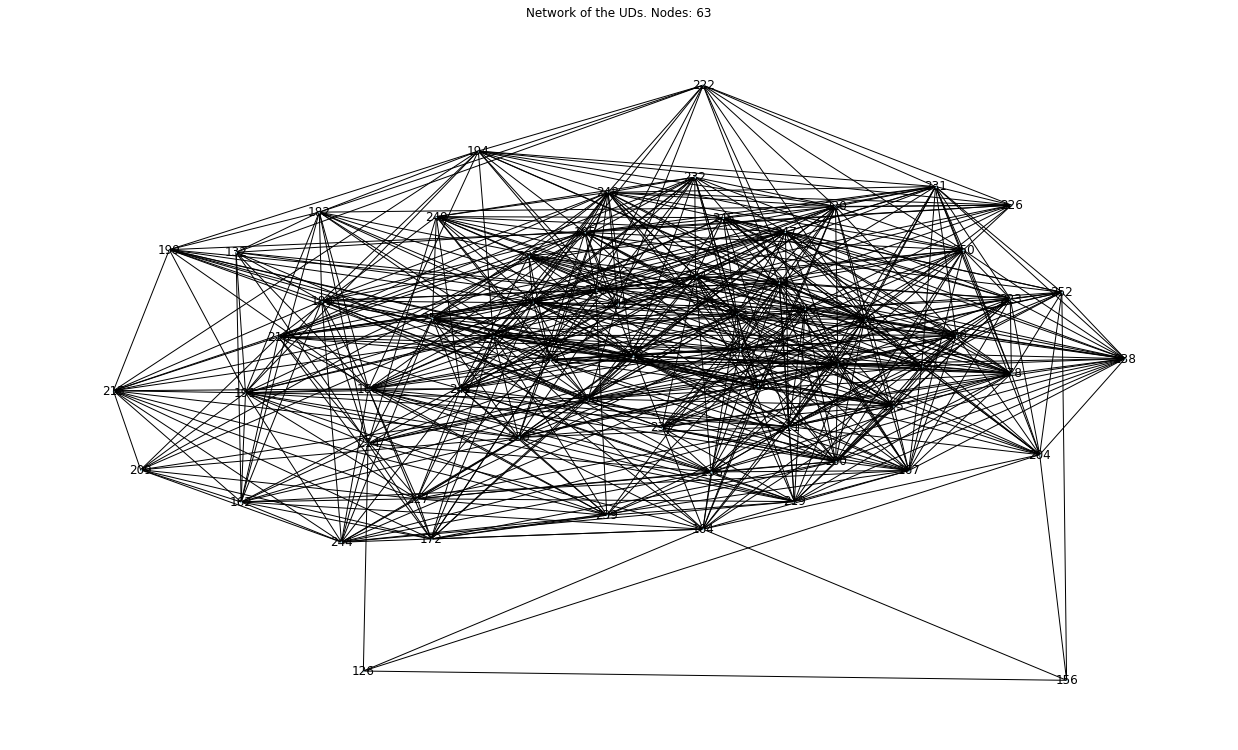

----------------------------


In [6]:
create_vis_geral(None, measures=False, df_step=ejemplo_conections)

In [22]:
ejemplo.head()
df = ejemplo

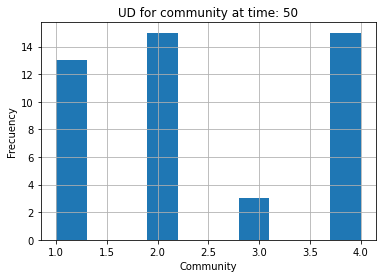

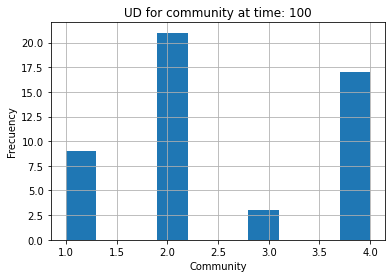

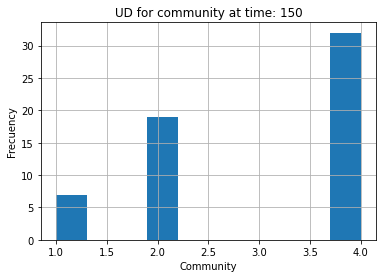

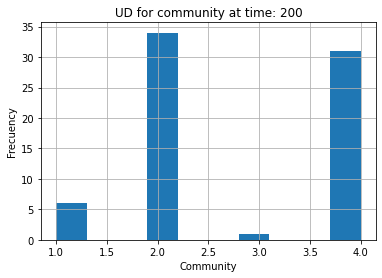

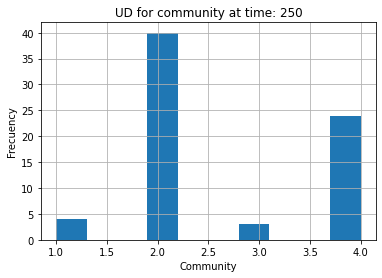

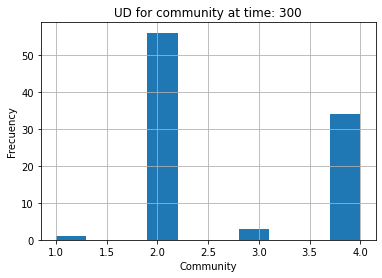

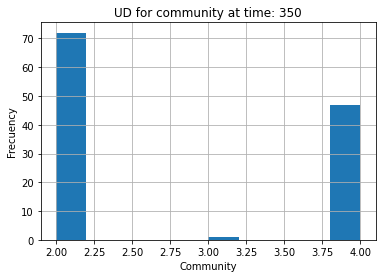

""


In [23]:
def histogram_UD_community(df_grupo):
    df_grupo["Community"].hist()
    plt.title(f"UD for community at time: {df_grupo['Step'].iloc[0]}")
    plt.xlabel("Community")
    plt.ylabel("Frecuency")
    plt.show()

df.groupby("Step").apply(histogram_UD_community)

In [25]:
def crear_red_step(df_step):
    """
    Crea una red NetworkX a partir de un dataframe filtrado por step.

    Args:
        df_step: Dataframe filtrado por un valor específico de step.

    Returns:
        Objeto NetworkX que representa la red en ese step.
    """
    # Crea un grafo vacío de NetworkX
    G = nx.Graph()

    # Agrega nodos al grafo
    nodos = df_step["source"].tolist() + df_step["target"].tolist()
    G.add_nodes_from(set(nodos))

    # Agrega aristas al grafo
    for i, fila in df_step.iterrows():
        source = fila["source"]
        target = fila["target"]
        G.add_edge(source, target)

    return G

In [29]:
steps_unicos

array([ 50, 100, 150, 200, 250, 300, 350], dtype=int64)

In [9]:
df = ejemplo
df

,Step,ID,Age,Parents,Community,Varieties
0,50,37,50,"[None, None, [51, 58, 64], None, None, None, N...",4,[<model_class.Variety.Variety object at 0x0000...
1,50,47,33,"[13, 17, [92, 100, 104], [], [49, 54, 73, 75, ...",2,[<model_class.Variety.Variety object at 0x0000...
2,50,50,33,"[27, 14, [92, 95, 100, 107], [], [67, 69, 70, ...",2,[<model_class.Variety.Variety object at 0x0000...
3,50,60,31,"[19, 36, [93, 98, 109, 117, 120], [], [74, 83]...",4,[<model_class.Variety.Variety object at 0x0000...
4,50,63,30,"[24, 16, [99, 127, 132], [], [41, 49, 71, 74],...",2,[<model_class.Variety.Variety object at 0x0000...
...,...,...,...,...,...,...
103,100,248,2,"[194, 179, None, [147, 140, 136, 131], [231, 2...",4,[<model_class.Variety.Variety object at 0x0000...
104,100,249,2,"[196, 171, None, [151, 137, 136, 124], [243, 2...",4,[<model_class.Variety.Variety object at 0x0000...
105,100,250,1,"[167, 185, None, [130, 123, 147, 135], [219, 2...",1,[<model_class.Variety.Variety object at 0x0000...
106,100,251,1,"[179, 195, None, [136, 131, 150, 128], [232, 2...",1,[<model_class.Variety.Variety object at 0x0000...


In [90]:
list(Gg.nodes())
for id_ud in list(Gg.nodes()):
    nx.set_node_attributes(Gg, {id_ud: {"Community": df_filtrado.loc[df_filtrado['ID'] == id_ud, 'Community'].iloc[0], 
                                        "Age": df_filtrado.loc[df_filtrado['ID'] == id_ud, 'Age'].iloc[0]}})

In [99]:
nx.get_node_attributes(Gg, "Age")

{126: 50,
 164: 33,
 156: 38,
 214: 12,
 204: 16,
 132: 48,
 182: 27,
 202: 18,
 222: 10,
 226: 8,
 240: 5,
 162: 34,
 168: 31,
 189: 25,
 191: 24,
 196: 24,
 252: 1,
 209: 15,
 215: 12,
 172: 30,
 167: 32,
 216: 12,
 227: 7,
 230: 7,
 244: 4,
 175: 29,
 176: 29,
 185: 26,
 198: 22,
 220: 10,
 228: 7,
 243: 4,
 246: 3,
 229: 7,
 236: 6,
 251: 1,
 219: 10,
 224: 9,
 233: 6,
 237: 5,
 238: 5,
 250: 1,
 178: 28,
 180: 27,
 171: 30,
 179: 28,
 193: 24,
 213: 12,
 223: 9,
 241: 5,
 239: 5,
 242: 4,
 194: 24,
 199: 21,
 218: 11,
 211: 15,
 235: 6,
 249: 2,
 232: 6,
 247: 2,
 248: 2,
 231: 7,
 245: 4}

In [89]:
df_filtrado.loc[df_filtrado['ID'] == 126, 'Community'].iloc[0]
df_filtrado.loc[df_filtrado['ID'] == 126, 'Age'].iloc[0]

50

In [50]:
steps_unicos = df["Step"].unique()
df_filtrado

,Step,ID,Age,Parents,Community,Varieties
45,100,126,50,"[83, 91, [163, 164, 183, 186], [36, 31, 46, 26...",3,[<model_class.Variety.Variety object at 0x0000...
46,100,132,48,"[63, 85, [182, 202], [24, 16, 38, 43], [99, 12...",1,[<model_class.Variety.Variety object at 0x0000...
47,100,156,38,"[91, 77, [204, 207], [46, 26, 33, 31], [126, 1...",4,[<model_class.Variety.Variety object at 0x0000...
48,100,162,34,"[120, 125, [203, 209, 215], [60, 85, 71, 86], ...",1,[<model_class.Variety.Variety object at 0x0000...
49,100,164,33,"[126, 128, [206, 214], [83, 91, 71, 101], [163...",1,[<model_class.Variety.Variety object at 0x0000...
...,...,...,...,...,...,...
103,100,248,2,"[194, 179, None, [147, 140, 136, 131], [231, 2...",4,[<model_class.Variety.Variety object at 0x0000...
104,100,249,2,"[196, 171, None, [151, 137, 136, 124], [243, 2...",4,[<model_class.Variety.Variety object at 0x0000...
105,100,250,1,"[167, 185, None, [130, 123, 147, 135], [219, 2...",1,[<model_class.Variety.Variety object at 0x0000...
106,100,251,1,"[179, 195, None, [136, 131, 150, 128], [232, 2...",1,[<model_class.Variety.Variety object at 0x0000...


In [33]:
for step in steps_unicos:
    df_filtrado = df[df["Step"] == step]

In [35]:
for i in len(df_filtrado):
    for j in range(2):
        step = df_filtrado.iloc[i]["Step"]
        source = df_filtrado.iloc[i]["ID"]
        target = df_filtrado.iloc[i][j]
    
    

63

[126,
 164,
 156,
 214,
 204,
 132,
 182,
 202,
 222,
 226,
 240,
 162,
 168,
 189,
 191,
 196,
 252,
 209,
 215,
 172,
 167,
 216,
 227,
 230,
 244,
 175,
 176,
 185,
 198,
 220,
 228,
 243,
 246,
 229,
 236,
 251,
 219,
 224,
 233,
 237,
 238,
 250,
 178,
 180,
 171,
 179,
 193,
 213,
 223,
 241,
 239,
 242,
 194,
 199,
 218,
 211,
 235,
 249,
 232,
 247,
 248,
 231,
 245]